<center>МИНИСТЕРСТВО НАУКИ И ВЫСШЕГО ОБРАЗОВАНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ </center>
<center>ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ </center>
<center>«НОВОСИБИРСКИЙ ГОСУДАРСТВЕННЫЙ ТЕХНИЧЕСКИЙ УНИВЕРСИТЕТ»</center>
<center>Кафедра Вычислительной техники </center>
<br>
<center> <b> <font size="5">  ОТЧЁТ </font>  </b>  </center>   
<center><font size="3">по лабораторной работе №3</font></center>
<center><font size="3">по дисциплине: «Системы искусственного интеллекта и машинное обучение» </font></center>
<br>

Выполнили студенты гр. АТМ-25:
- Чумаков И.В.
- Секачёв Г.М.

Проверил: 

<center>  Новосибирск, 2025  </center>


# Лабораторная работа #3

## Цель работы

Знакомство и работа с моделью машинного обучения типа "многослойный перцептрон" для решения задачи регрессии с использованием библиотеки Tensorflow.

## Содержание отчета

1. Список выбранных целевой переменной 'y' и независимых признаков 'x1, x2, x3, ...'

2. Описание процесса загрузки и НОРМАЛИЗАЦИИ с выводом значений таблиц

3. Гистограммы распределения исходных и шкалированных значений для целевой переменной 'y' и независимых признаков 'x1, x2, x3, ...'

4. Этапы построения и оценки  точности моделей (m1, m2, m3, m4)
  
5. Сводная таблица оценок точности с указанием структуры модели

6. Выводы по результатам сравнительного анализа полученных регрессионных моделей

# Подключение библиотек

In [55]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [56]:
import tensorflow as tf

In [57]:
import plotly.graph_objects as go

## Объявление функций

In [58]:
def PLOT34(y_test, y_pred) -> None:
    """
    Функция построения графиков
    :param y_test: - проверочные значения целевой переменной
    :param y_pred: - вычисленные значения целевой переменной
    """
    plt.figure(figsize=(12, 6))

    # == Диаграмма рассеяния вычисленных значений ==
    # создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс текущего полотна в сетке
    plt.subplot(121)
    plt.scatter(y_test, y_pred, alpha=0.1, color="#17becf")
    plt.axline(
        (0, 0),
        slope=1,
        color="black",
        linestyle="--",
        linewidth=3,
        alpha=0.7,
    )
    range_test, range_pred = np.max(y_test) - np.min(y_test), np.max(y_pred) - np.min(y_pred)
    if range_test / range_pred < 4 and range_test / range_pred > 0.25:
        plt.gca().set_aspect("equal")
        axmin, axmax = np.min([y_test, y_pred]), np.max([y_test, y_pred])
        plt.xlim([axmin, axmax])
        plt.ylim([axmin, axmax])
    plt.title("Диаграмма рассеяния вычисленных значений")
    plt.xlabel("Проверочное Y")
    plt.ylabel("Вычисленное Y")
    plt.grid(True, alpha=0.5)  # Сетка

    # == Диаграмма рассеяния ошибок ==
    # создать второе полотно 121: 1-строк, 2-столбцов, 2-индекс текущего полотна в сетке
    plt.subplot(122)
    plt.scatter(y_test, (y_test - y_pred) ** 2, alpha=0.1, color="#17becf")
    plt.title("Диаграмма рассеяния квадрата абсолютной ошибки")
    plt.xlabel("Проверочное Y")
    plt.ylabel("Квадрат абсолютной ошибки")
    plt.grid(True, alpha=0.5)  # Сетка


# --------------------------------------------------------------------------

In [59]:
def GET_METRICS_SINGLE(y_test, y_pred) -> None:
    """
    Вычисление и вывод метрик: MAE, RMSE, R2. Используются функции из библиотеки sklearn. На основе сравнения проверочных и вычисленных значений.
    :param y_test: - проверочные значения целевой переменной
    :param y_pred: - вычисленные значения целевой переменной
    Возвращает словарь (хэш-таблицу) со значениями метрик
    """
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_test, y_pred)
    print("MAE : {:>9,.3f} (средняя абсолютная ошибка)".format(mae))
    print("MSE : {:>9,.6f} (среднеквадратичная ошибка)".format(mse))
    print("RMSE: {:>9,.6f} (кв. корень из среднеквадратичной ошибки)".format(rmse))
    print("R2  : {:>9,.3f} (коэфф. детерминации)".format(r2))
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}


# --------------------------------------------------------------------------

In [60]:
def my3dplot(
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    isDrawTrain: bool,
    x_test: pd.DataFrame,
    y_test: pd.DataFrame,
    isDrawTest: bool,
    y_pred: pd.DataFrame,
    isDrawPred: bool,
    x1Name: str,
    x2Name: str,
    y_targetName: str,
    pointSize=5,  # Размер точки
    pointTransparency=0.25,  # Прозрачность точек графика train, test
    meshTransparency=0.5,  # Прозрачность поверхности вычисленных значений y_pred
) -> None:
    """
    Отображает 3D график исходных и вычисленых точек
    x_test, y_test, x_train, y_train - обучающая и проверочная части исходной таблицы  (тип DataFrame)
    y_pred, - вычисленные значения (тип DataFrame)
    x1Name, x2Name - имя столбца для x1 и x2 (тип строковый)
    y_targetName   - имя столбца целевого    (тип строковый)
    """
    # Построить поверхность, соотвествующую вычисленным значениям
    trace_ModelPredicted = go.Mesh3d(
        x=x_test[x1Name].values,
        y=x_test[x2Name].values,
        z=y_pred.reshape(-1),  # <-- Вычисленные
        name="Вычисленный",
        opacity=meshTransparency,
        # alphahull=1,
        color="rgb(244,100,100)",  #  rgba(100,244,100, 0.6)
    )

    # Построить рассеяние обучающих точек
    trace_Train = go.Scatter3d(
        x=x_train[x1Name].values,  # <-- Обучающие
        y=x_train[x2Name].values,  # <-- Обучающие
        z=y_train[y_targetName].values,  # <-- Обучающие
        name="Обучающие",
        mode="markers",
        marker=dict(
            size=pointSize,
            color="#1f77b4",  # Цвет точек <-- Проверочные
            # color=y_train[ y_targetName ].values, # Источник значений цвета <-- Обучающие
            # colorscale='Blues',        # Название цветовой шкалы # _r
            opacity=pointTransparency,
        ),
    )

    # Построить рассеяние проверочных точек
    trace_Test = go.Scatter3d(
        x=x_test[x1Name].values,  # <-- Проверочные
        y=x_test[x2Name].values,  # <-- Проверочные
        z=y_test[y_targetName].values,  # <-- Проверочные
        name="Проверочные",
        mode="markers",
        marker=dict(
            size=pointSize,
            color="#ff7f0e",  # Цвет точек <-- Проверочные
            # color=y_test[y_targetName].values, # Источник значений цвета <-- Проверочные
            # colorscale='Oranges',        # Название цветовой шкалы # _r
            opacity=pointTransparency,
        ),
    )

    # Составить список элементов к отрисовке на графике
    ListForDraw = []
    if isDrawTrain:
        ListForDraw.append(trace_Train)
    if isDrawTest:
        ListForDraw.append(trace_Test)
    if isDrawPred:
        ListForDraw.append(trace_ModelPredicted)

    # Отрисовать все указанные элементы
    fig = go.Figure(data=ListForDraw)

    # Добавить подписи осей
    fig.update_layout(
        width=800,
        height=600,
        title="Завиcимость {} от ({}, {})".format(y_targetName, x1Name, x2Name),
        scene=dict(
            xaxis_title=x1Name,
            yaxis_title=x2Name,
            zaxis_title=y_targetName,
        ),
    )
    fig.show()


# --------------------------------------------------------------------------

In [61]:
def printModelWeights(model):
    # Вывод структуры и значений весовых коэфф. нейросети по слоям
    for layer in model.layers:
        print(f"{'#' * 100}")
        print(f"#### Имя слоя:{layer.name};  Тип слоя: {layer.__class__} ##########", end="")
        print(f"\nВид ф-ии активации слоя: {layer.get_config()['activation']}", end="")
        print(f"\nКол-во ВХодов  слоя: {layer.input.shape[1]}", end="")
        print(f"\nКол-во ВЫХодов слоя: {layer.output.shape[1]}", end="")
        if type(layer) is tf.keras.layers.Dense:
            print(f"\nКол-во нейронов слоя:    {layer.get_config()['units']}", end="")
            print(f"\n\nВесовые коэфф. weight_i_j=\n{layer.weights[0].numpy()}")
            print(f"\nВесовые коэфф. bias_i_j=\n{layer.bias.numpy()}")
        elif type(layer) is tf.keras.layers.Activation:
            pass
        print("\n")

# Tensorflow. Проверка работы нейросети на искусственных данных

Для последующего сравнения получим модель нейронной сети обученной на  почти "идеальных" входных данных, т.е. с четко прослеживаемой зависимостью переменных и контролируемым уровнем шумов.

Цель данного шага - продемонстрировать работоспособность применения НС для решения задачи регрессии.

# Загрузка данных

In [62]:
df = pd.read_csv(
    "../datasets/SkillCraft1_Dataset_nan_PREPARED.csv",
    sep=",",
    header=0,
)
print("Размер таблицы", df.shape)
df[:2]

Размер таблицы (2893, 20)


,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5.0,27.0,10.0,3000.0,143.7180,0.003515,0.000220,7.0,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28.0,0.001397,6.0,0.0,0.000000
1,55,5.0,23.0,10.0,5000.0,129.2322,0.003304,0.000259,4.0,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22.0,0.001193,5.0,0.0,0.000208


# Приведение к новой единой шкале. Нормализация

## Выделение X и Y

Для выполнения следующих шагов разделим исходную таблицу на две отдельных
  - dfX содержащую только объясняющие признаки
  - dfY содержащую только целевой объясняемый признак

In [63]:
features = df.columns.tolist()
feat_to_remove = ["LeagueIndex", "GameID", "TotalHours"]
features = [feat for feat in features if feat not in feat_to_remove]
target = ["LeagueIndex"]

In [112]:
dfX = df[features_from_lab1]
print("Размер таблицы", dfX.shape)
dfX[3:7]

Размер таблицы (2893, 6)


,ActionLatency,APM,NumberOfPACs,AssignToHotkeys,SelectByHotkeys,UniqueHotkeys
3,53.7352,107.6016,0.003783,0.000213,0.001034,1.0
4,62.0813,122.8908,0.002368,0.000327,0.001136,2.0
5,98.7719,44.4570,0.002425,0.000255,0.000978,2.0
6,90.5311,46.9962,0.001988,0.000169,0.000820,6.0


In [113]:
dfX[3:7].to_csv("dfX_sample.csv", index=False)

In [110]:
dfY = df[target]
print("Размер таблицы", dfY.shape)
dfY[3:7]

Размер таблицы (2893, 1)


,LeagueIndex
3,3.0
4,3.0
5,2.0
6,1.0


## Использование класса MinMaxScaler

In [106]:
features_from_lab1 = [
        "ActionLatency",
        "APM",
        "NumberOfPACs",
        "AssignToHotkeys",
        "SelectByHotkeys",
        "UniqueHotkeys"
]
    
scalerNormX = MinMaxScaler()
scalerNormX.fit(dfX[features_from_lab1])

dfXNorm = pd.DataFrame(data=scalerNormX.transform(dfX[features_from_lab1]), columns=features_from_lab1, index=dfX.index)
print("Размер таблицы", dfXNorm.shape)
dfXNorm[:2]

Размер таблицы (2893, 6)


,ActionLatency,APM,NumberOfPACs,AssignToHotkeys,SelectByHotkeys,UniqueHotkeys
0,0.127426,0.568487,0.778197,0.236437,0.335180,0.7
1,0.146434,0.495967,0.663114,0.279231,0.315028,0.4


In [ ]:
dfXNorm[:3].to_csv("dfXNorm_sample.csv", index=False)

In [68]:
scalerNormY = MinMaxScaler()
scalerNormY.fit(dfY)

dfYNorm = pd.DataFrame(data=scalerNormY.transform(dfY), columns=dfY.columns, index=dfY.index)
print("Размер таблицы", dfYNorm.shape)
dfYNorm[:2]

Размер таблицы (2893, 1)


,LeagueIndex
0,0.666667
1,0.666667


In [107]:
import pickle

pickle.dump(scalerNormX, open("scalerX_NN_6.pkl", "wb"))

## Проверка нормализации

Осмотрим гистограммы по каждому признаку и проверим их мин. и макс. значения.

In [70]:
dfXNorm.describe().loc[["min", "max"]]

,Age,HoursPerWeek,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [71]:
dfYNorm.describe().loc[["min", "max"]]

,LeagueIndex
min,0.0
max,1.0


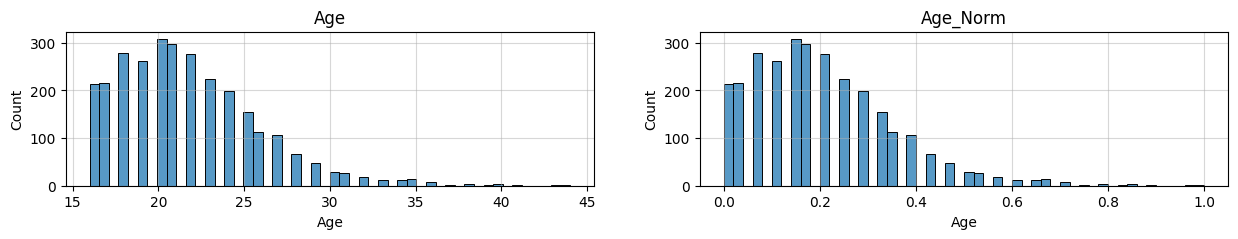

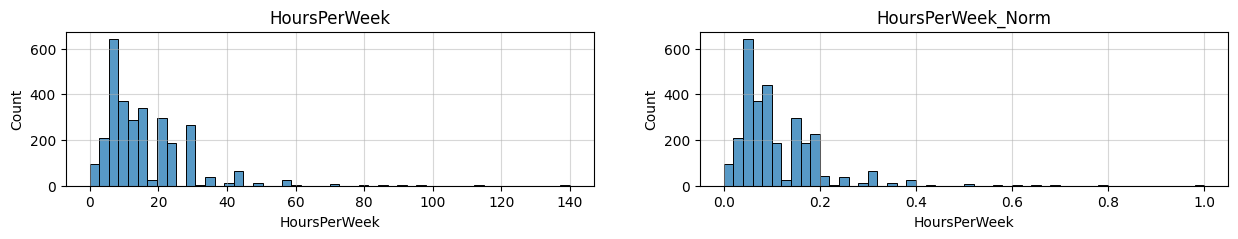

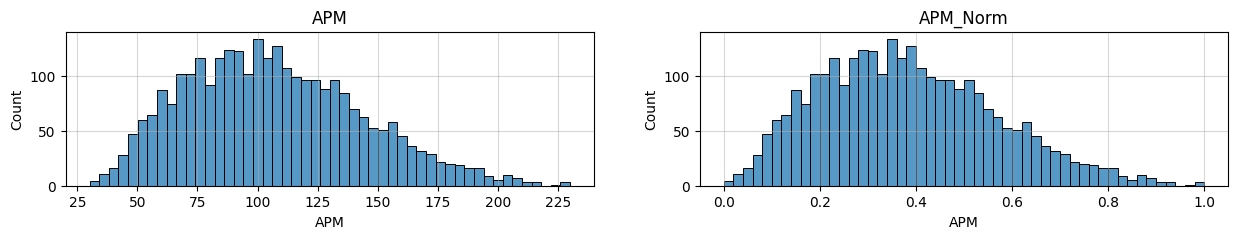

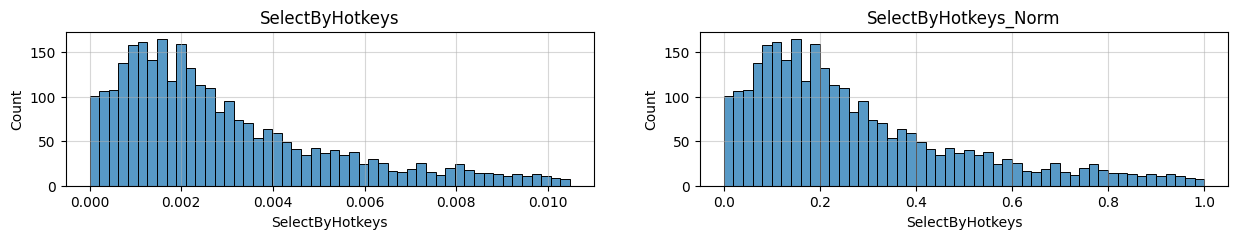

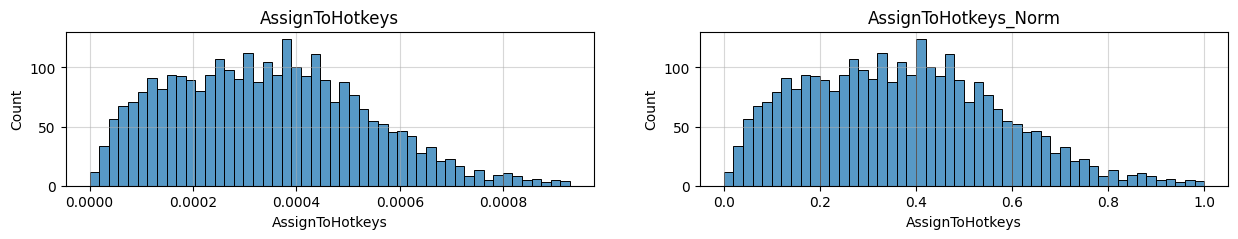

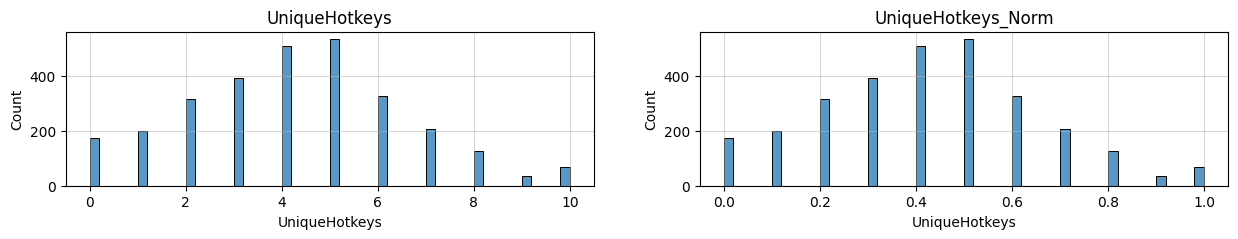

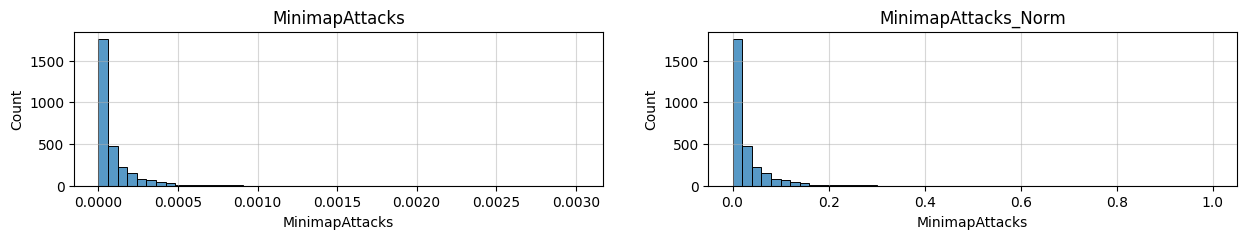

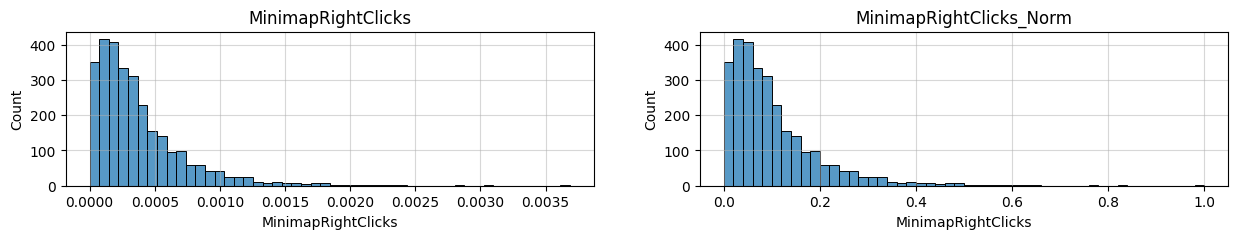

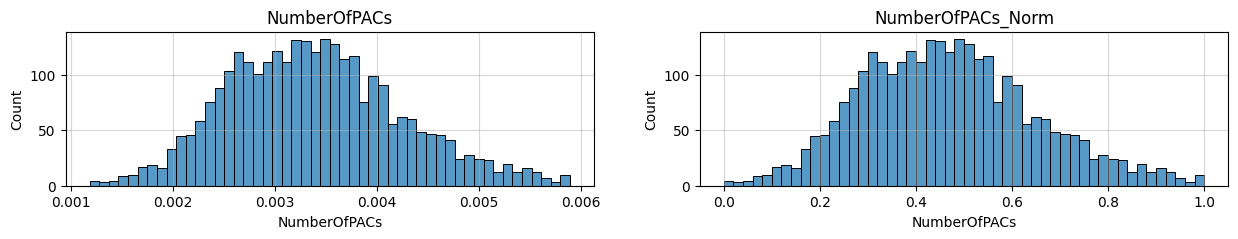

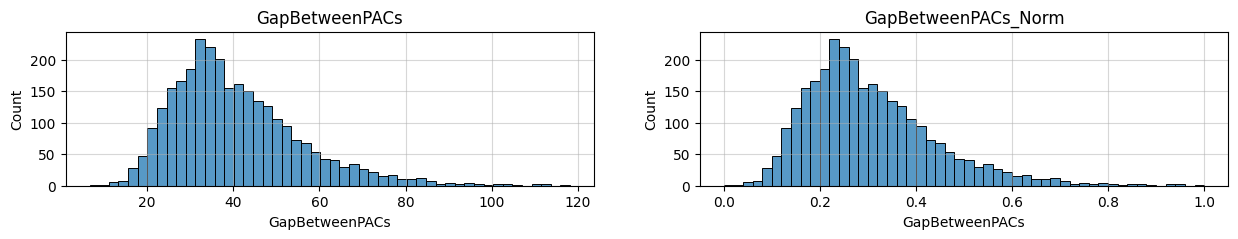

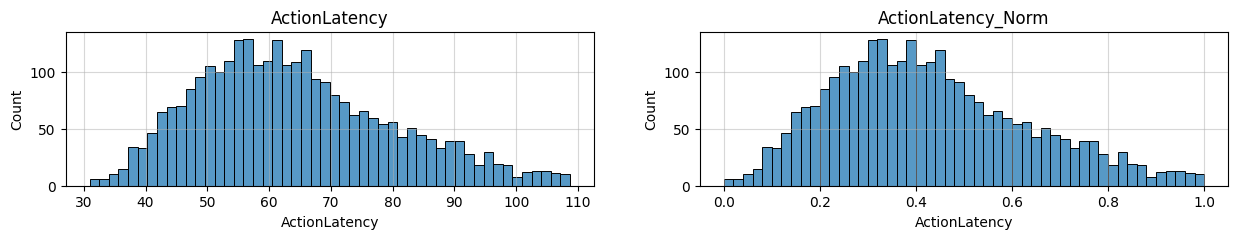

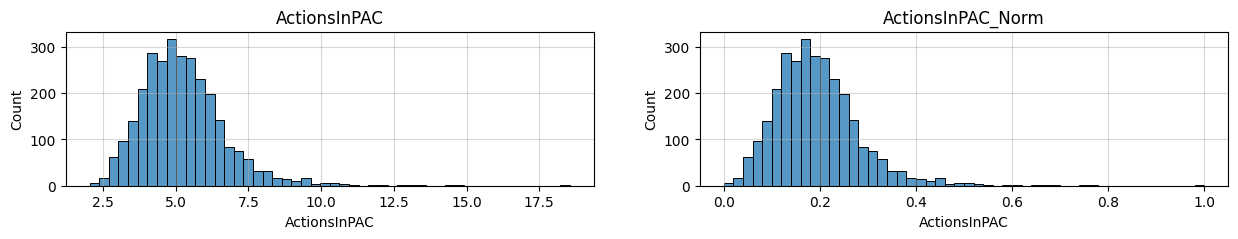

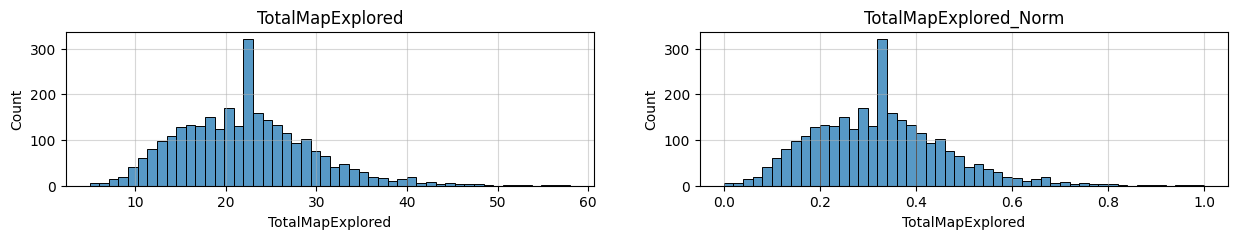

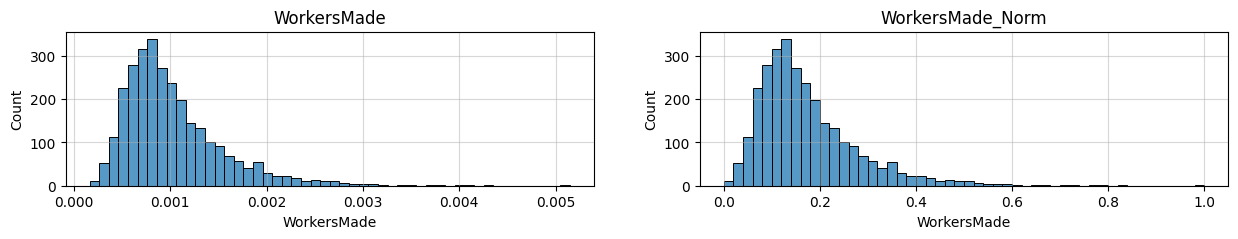

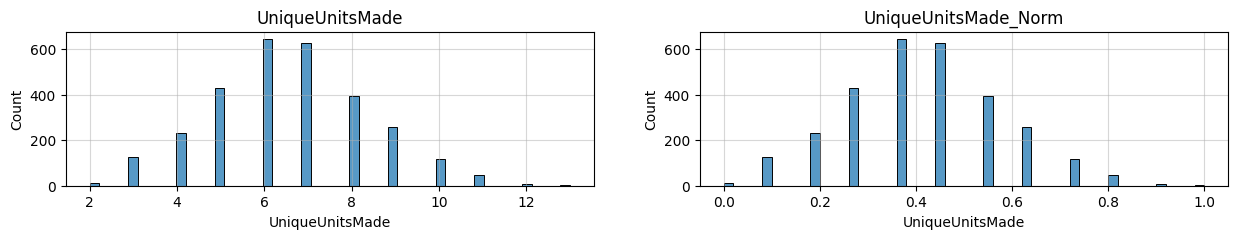

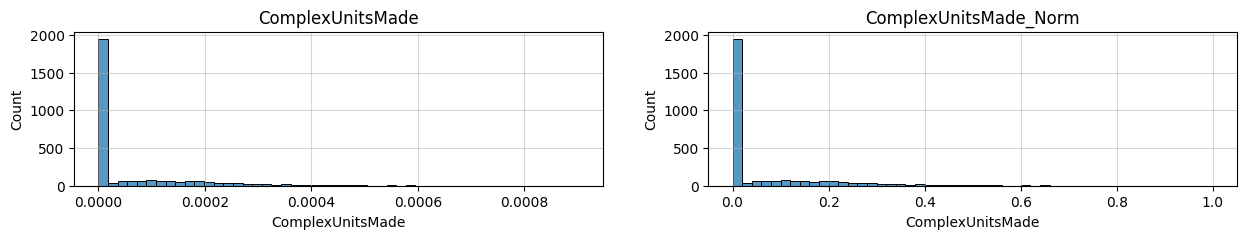

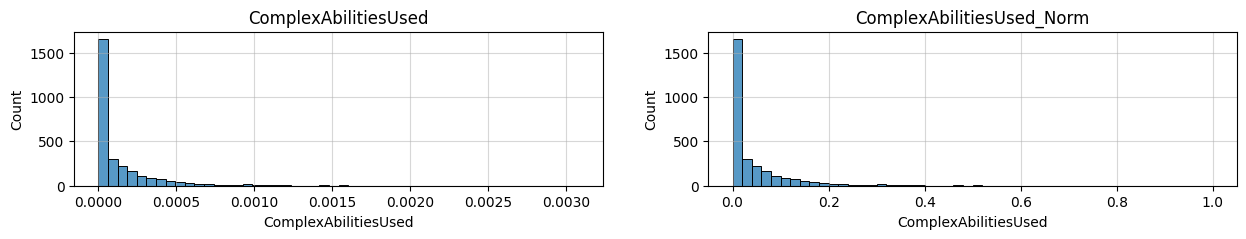

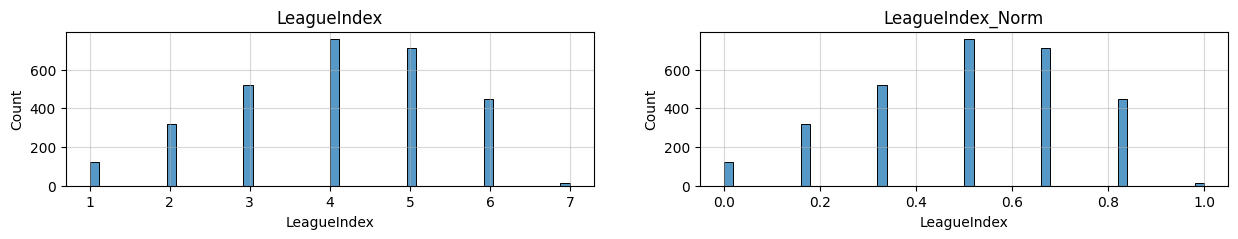

In [72]:
for dfN in [dfXNorm, dfYNorm]:
    for i, colName in enumerate(dfN.columns):
        plt.figure(figsize=(15, 2))

        plt.subplot(1, 2, 1)
        sns.histplot(df[colName], bins=50)
        plt.title(colName)
        plt.grid(True, alpha=0.5)

        plt.subplot(1, 2, 2)
        sns.histplot(dfN[colName], bins=50)
        plt.title(colName + "_Norm")
        plt.grid(True, alpha=0.5)

# Формирование тренировочной и проверочной выборок

In [73]:
valid_size = 0.3
rand_seed = 42

## Нормализованые

In [74]:
xNorm_train, xNorm_test, yNorm_train, yNorm_test = train_test_split(
    dfXNorm[features],
    dfYNorm[target],
    test_size=valid_size,
    random_state=rand_seed,
    shuffle=True,
)

In [75]:
xNorm_train[:2]

,Age,HoursPerWeek,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
2215,0.107143,0.042857,0.364835,0.474392,0.594911,1.0,0.024966,0.040883,0.551537,0.368809,0.313655,0.109267,0.245283,0.107999,0.272727,0.0,0.0
1210,0.107143,0.085714,0.223547,0.009703,0.146024,0.2,0.011235,0.045993,0.317577,0.631055,0.548624,0.195342,0.132075,0.109765,0.090909,0.0,0.0


In [76]:
yNorm_train[:2]

,LeagueIndex
2215,0.333333
1210,0.500000


# Нейронная сеть m1. Построение модели без скрытых слоев от ДВУХ "x" (2_вх->1_вых)

## Структура и параметры

In [77]:
totalHistoryLossTrain = []
totalHistoryLossTest = []

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(2,)))

model.add(tf.keras.layers.Dense(units=1, activation=None))

fLoss = tf.keras.losses.MeanSquaredError()

fOptimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
fMetricList = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]

model.compile(loss=fLoss, optimizer=fOptimizer, metrics=fMetricList)

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

None


## Первичное и дополнительное обучение

In [78]:
xNorm_train.columns

Index(['Age', 'HoursPerWeek', 'APM', 'SelectByHotkeys', 'AssignToHotkeys',
       'UniqueHotkeys', 'MinimapAttacks', 'MinimapRightClicks', 'NumberOfPACs',
       'GapBetweenPACs', 'ActionLatency', 'ActionsInPAC', 'TotalMapExplored',
       'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade',
       'ComplexAbilitiesUsed'],
      dtype='object')

In [79]:
# Осмотрим используемые для обучения столбцы исходной таблицы
xNorm_train[["APM", "NumberOfPACs"]]

,APM,NumberOfPACs
2215,0.364835,0.551537
1210,0.223547,0.317577
821,0.313320,0.379129
343,0.239049,0.513006
2655,0.433648,0.517122
...,...,...
1638,0.098019,0.155094
1095,0.456555,0.553281
1130,0.669976,0.224502
1294,0.257255,0.431911


In [80]:
# Осмотрим используемые для обучения столбцы исходной таблицы
yNorm_train

,LeagueIndex
2215,0.333333
1210,0.500000
821,0.500000
343,0.333333
2655,0.500000
...,...
1638,0.000000
1095,0.333333
1130,0.666667
1294,0.833333


In [81]:
epochForTrain = 20

history = model.fit(
    xNorm_train[["APM", "NumberOfPACs"]],
    yNorm_train,
    validation_data=(xNorm_test[["APM", "NumberOfPACs"]], yNorm_test),
    epochs=epochForTrain,
    verbose=1,
)

totalHistoryLossTrain.extend(history.history["loss"])
if "val_loss" in history.history.keys():
    totalHistoryLossTest.extend(history.history["val_loss"])

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0541 - mean_absolute_error: 0.1812 - mean_squared_error: 0.0538 - val_loss: 0.0443 - val_mean_absolute_error: 0.1656 - val_mean_squared_error: 0.0437
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0395 - mean_absolute_error: 0.1586 - mean_squared_error: 0.0395 - val_loss: 0.0391 - val_mean_absolute_error: 0.1555 - val_mean_squared_error: 0.0385
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0362 - mean_absolute_error: 0.1523 - mean_squared_error: 0.0360 - val_loss: 0.0363 - val_mean_absolute_error: 0.1505 - val_mean_squared_error: 0.0357
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0343 - mean_absolute_error: 0.1492 - mean_squared_error: 0.0344 - val_loss: 0.0342 - val_mean_absolute_error: 0.1460 - val_mean_squared_error: 0.0336
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0333 - mean_absolute_error: 0.1464 - mean_squared_error: 0.0332 - val_loss: 0.0339 - val_mean_absolu

## Оценка точности

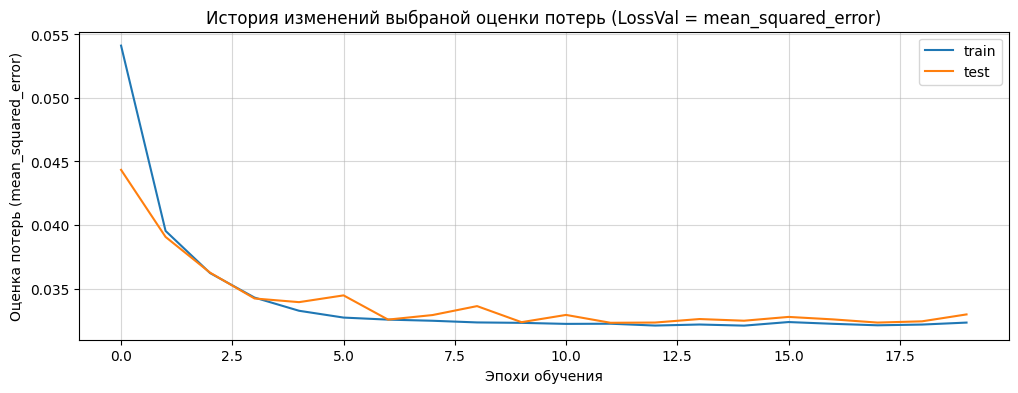

In [82]:
plt.figure(figsize=(12, 4))
plt.plot(totalHistoryLossTrain, label="train", color="#1f77b4")
if "val_loss" in history.history.keys():
    plt.plot(totalHistoryLossTest, label="test", color="#ff7f0e")
plt.title("История изменений выбраной оценки потерь (LossVal = mean_squared_error)")
plt.ylabel("Оценка потерь (mean_squared_error)")
plt.xlabel("Эпохи обучения")
plt.legend()
plt.grid(True, alpha=0.5)

In [83]:
totalHistoryLossTrain[-5:]

[0.03237084671854973,
 0.03223201259970665,
 0.03211543336510658,
 0.03217361122369766,
 0.03232865780591965]

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAE :     0.146 (средняя абсолютная ошибка)
MSE :  0.032971 (среднеквадратичная ошибка)
RMSE:  0.181580 (кв. корень из среднеквадратичной ошибки)
R2  :     0.332 (коэфф. детерминации)


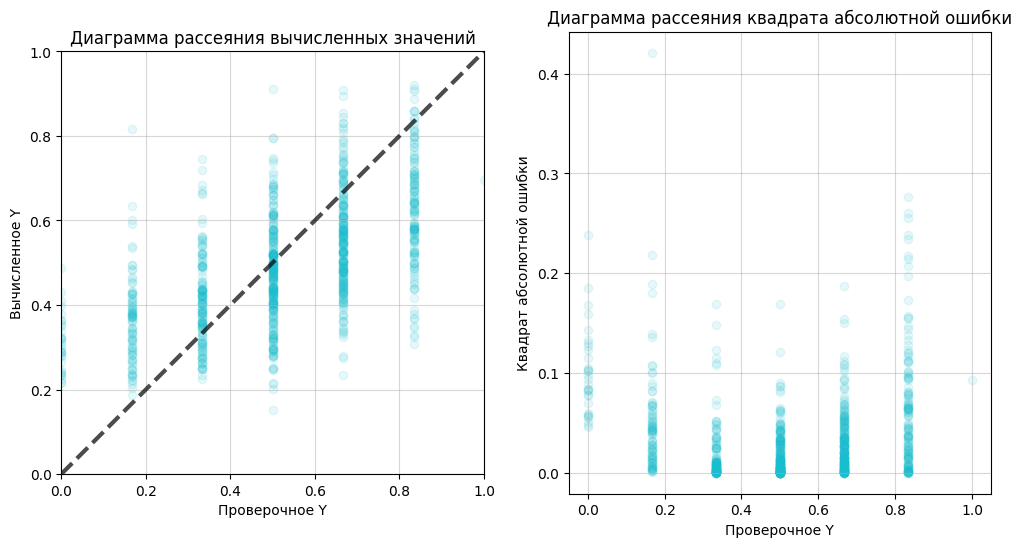

In [84]:
yNorm_pred = model.predict(xNorm_test[["APM", "NumberOfPACs"]])

GET_METRICS_SINGLE(yNorm_test, yNorm_pred) 
PLOT34(yNorm_test, yNorm_pred)

In [85]:
yNorm_pred[0:5]

array([[0.45254317],
       [0.68130124],
       [0.29397237],
       [0.44017705],
       [0.4892582 ]], dtype=float32)

## Получение весовых коэфф. w_i и bias для модели m1 (2_вх->1_вых)

In [86]:
printModelWeights(model)

####################################################################################################
#### Имя слоя:dense_5;  Тип слоя: <class 'keras.src.layers.core.dense.Dense'> ##########
Вид ф-ии активации слоя: linear
Кол-во ВХодов  слоя: 2
Кол-во ВЫХодов слоя: 1
Кол-во нейронов слоя:    1

Весовые коэфф. weight_i_j=
[[0.54965466]
 [0.34103453]]

Весовые коэфф. bias_i_j=
[0.1177908]




## Построение 3d графика зависимости вычисленных значений Y_pred от объясняющих признаков x1 и x2

In [87]:
my3dplot(
    xNorm_train,
    yNorm_train,
    True,  # Обучающие x и y, Флаг отображения обучающих точек  (синие)
    xNorm_test,
    yNorm_test,
    True,  # Проверочные x и y, Флаг отображения проверочных точек   (оранжевые)
    yNorm_pred,
    True,  # Вычисленные y, Флаг отображения вычисленной функции  (зелёные)
    x1Name="APM",
    x2Name="NumberOfPACs",
    y_targetName=target[0],  # Имена столбцов из таблиц  xNorm_train, xNorm_test, yNorm_pred
    pointSize=5,  # Размер точки
    pointTransparency=0.4,  # Прозрачность точек графика train, test
    meshTransparency=0.3,  # Прозрачность поверхности вычисленных значений y_pred
)

# Нейронная сеть m2. Построение модели со скрытыми слоями от ДВУХ "x" (2_вх-> 20 -> 20 -> 20 ->1_вых)

In [88]:
totalHistoryLossTrain = []
totalHistoryLossTest = []


model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(2,)))

model.add(tf.keras.layers.Dense(units=20, activation=None))
model.add(tf.keras.layers.Activation(activation=tf.keras.activations.relu))

model.add(tf.keras.layers.Dense(units=20, activation=None))
model.add(tf.keras.layers.Activation(activation=tf.keras.activations.relu))

model.add(tf.keras.layers.Dense(units=20, activation=None))
model.add(tf.keras.layers.Activation(activation=tf.keras.activations.relu))

model.add(tf.keras.layers.Dense(units=1, activation=None))

fLoss = tf.keras.losses.MeanSquaredError()

fOptimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
fMetricList = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]

model.compile(loss=fLoss, optimizer=fOptimizer, metrics=fMetricList)

print(model.summary())


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 921 (3.60 KB)

 Trainable params: 921 (3.60 KB)

 Non-trainable params: 0 (0.00 B)

None


In [89]:
epochForTrain = 40

history = model.fit(
    xNorm_train[["APM", "NumberOfPACs"]],
    yNorm_train,
    validation_data=(xNorm_test[["APM", "NumberOfPACs"]], yNorm_test),
    epochs=epochForTrain,
    verbose=1,
)

totalHistoryLossTrain.extend(history.history["loss"])
if "val_loss" in history.history.keys():
    totalHistoryLossTest.extend(history.history["val_loss"])

Epoch 1/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0381 - mean_absolute_error: 0.1548 - mean_squared_error: 0.0380 - val_loss: 0.0365 - val_mean_absolute_error: 0.1556 - val_mean_squared_error: 0.0361
Epoch 2/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0341 - mean_absolute_error: 0.1488 - mean_squared_error: 0.0342 - val_loss: 0.0322 - val_mean_absolute_error: 0.1410 - val_mean_squared_error: 0.0314
Epoch 3/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0331 - mean_absolute_error: 0.1456 - mean_squared_error: 0.0329 - val_loss: 0.0316 - val_mean_absolute_error: 0.1403 - val_mean_squared_error: 0.0309
Epoch 4/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0326 - mean_absolute_error: 0.1468 - mean_squared_error: 0.0328 - val_loss: 0.0353 - val_mean_absolute_error: 0.1509 - val_mean_squared_error: 0.0349
Epoch 5/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0328 - mean_absolute_error: 0.1462 - mean_squared_error: 0.0327 - val_loss: 0.0321 - val_mean_absolu

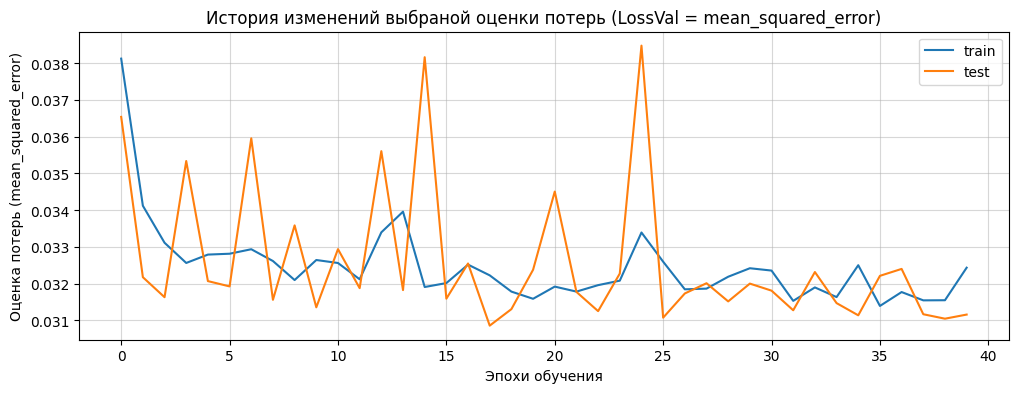

In [90]:
plt.figure(figsize=(12, 4))
plt.plot(totalHistoryLossTrain, label="train", color="#1f77b4")
plt.plot(totalHistoryLossTest, label="test", color="#ff7f0e")
plt.title("История изменений выбраной оценки потерь (LossVal = mean_squared_error)")
plt.ylabel("Оценка потерь (mean_squared_error)")
plt.xlabel("Эпохи обучения")
plt.legend()
plt.grid(True, alpha=0.5)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE :     0.141 (средняя абсолютная ошибка)
MSE :  0.031154 (среднеквадратичная ошибка)
RMSE:  0.176505 (кв. корень из среднеквадратичной ошибки)
R2  :     0.369 (коэфф. детерминации)


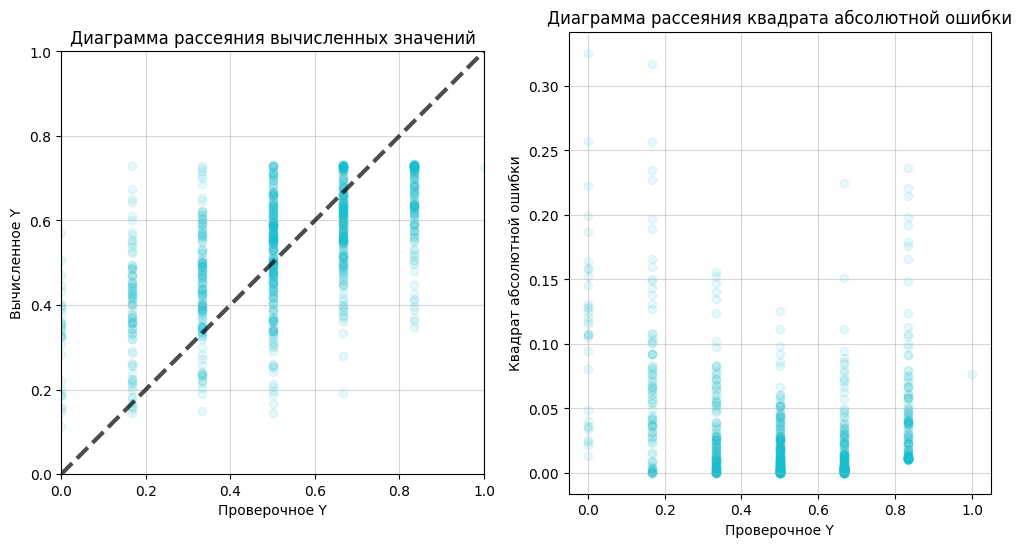

In [91]:
yNorm_pred = model.predict(xNorm_test[["APM", "NumberOfPACs"]])

GET_METRICS_SINGLE(yNorm_test, yNorm_pred)
PLOT34(yNorm_test, yNorm_pred)

In [92]:
model.save('NN_2.keras')

import json

model_info = {
    "model_type": "Нейронная сеть на 2 параметрах",
    "needs_scaling": True,
    "features": ["APM", "NumberOfPACs"],
    "target": target,
    "R2": 0.349,
    "RMSE": 0.179304,
    "coefs": "NN_2.keras"
}

json.dump(model_info, open("NN_2.json", "w"), indent=4)

In [93]:
my3dplot(
    xNorm_train,
    yNorm_train,
    True,  # Обучающие x и y, Флаг отображения обучающих точек  (синие)
    xNorm_test,
    yNorm_test,
    True,  # Проверочные x и y, Флаг отображения проверочных точек   (оранжевые)
    yNorm_pred,
    True,  # Вычисленные y, Флаг отображения вычисленной функции  (зелёные)
    x1Name="APM",
    x2Name="NumberOfPACs",
    y_targetName=target[0],  # Имена столбцов из таблиц  xNorm_train, xNorm_test, yNorm_pred
    pointSize=5,  # Размер точки
    pointTransparency=0.4,  # Прозрачность точек графика train, test
    meshTransparency=0.3,  # Прозрачность поверхности вычисленных значений y_pred
)

# Нейронная сеть m3. Построение модели без скрытых слоев от множества "x"  (6_вх->1_вых))

In [94]:
totalHistoryLossTrain = []
totalHistoryLossTest = []


model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(6,)))

model.add(tf.keras.layers.Dense(units=1, activation=None))

fLoss = tf.keras.losses.MeanSquaredError()

fOptimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
fMetricList = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]

model.compile(loss=fLoss, optimizer=fOptimizer, metrics=fMetricList)

print(model.summary())


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [95]:
features_from_lab1 = [
    "ActionLatency",
    "APM",
    "NumberOfPACs",
    "AssignToHotkeys",
    "SelectByHotkeys",
    "UniqueHotkeys",
]

In [96]:
epochForTrain = 40

history = model.fit(
    xNorm_train[features_from_lab1],
    yNorm_train,
    validation_data=(xNorm_test[features_from_lab1], yNorm_test),
    epochs=epochForTrain,
    verbose=1,
)

totalHistoryLossTrain.extend(history.history["loss"])
if "val_loss" in history.history.keys():
    totalHistoryLossTest.extend(history.history["val_loss"])

Epoch 1/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4096 - mean_absolute_error: 0.4999 - mean_squared_error: 0.4054 - val_loss: 0.0802 - val_mean_absolute_error: 0.2204 - val_mean_squared_error: 0.0790
Epoch 2/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0640 - mean_absolute_error: 0.2003 - mean_squared_error: 0.0650 - val_loss: 0.0621 - val_mean_absolute_error: 0.1979 - val_mean_squared_error: 0.0613
Epoch 3/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0511 - mean_absolute_error: 0.1799 - mean_squared_error: 0.0510 - val_loss: 0.0503 - val_mean_absolute_error: 0.1785 - val_mean_squared_error: 0.0495
Epoch 4/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0435 - mean_absolute_error: 0.1667 - mean_squared_error: 0.0434 - val_loss: 0.0433 - val_mean_absolute_error: 0.1647 - val_mean_squared_error: 0.0424
Epoch 5/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0391 - mean_absolute_error: 0.1585 - mean_squared_error: 0.0389 - val_loss: 0.0394 - val_mean_absolu

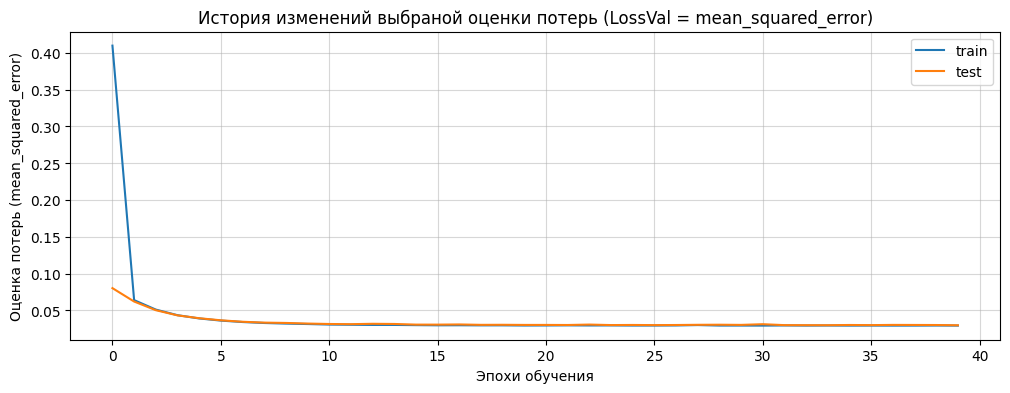

In [97]:
plt.figure(figsize=(12, 4))
plt.plot(totalHistoryLossTrain, label="train", color="#1f77b4")
plt.plot(totalHistoryLossTest, label="test", color="#ff7f0e")
plt.title("История изменений выбраной оценки потерь (LossVal = mean_squared_error)")
plt.ylabel("Оценка потерь (mean_squared_error)")
plt.xlabel("Эпохи обучения")
plt.legend()
plt.grid(True, alpha=0.5) 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAE :     0.137 (средняя абсолютная ошибка)
MSE :  0.029821 (среднеквадратичная ошибка)
RMSE:  0.172686 (кв. корень из среднеквадратичной ошибки)
R2  :     0.396 (коэфф. детерминации)


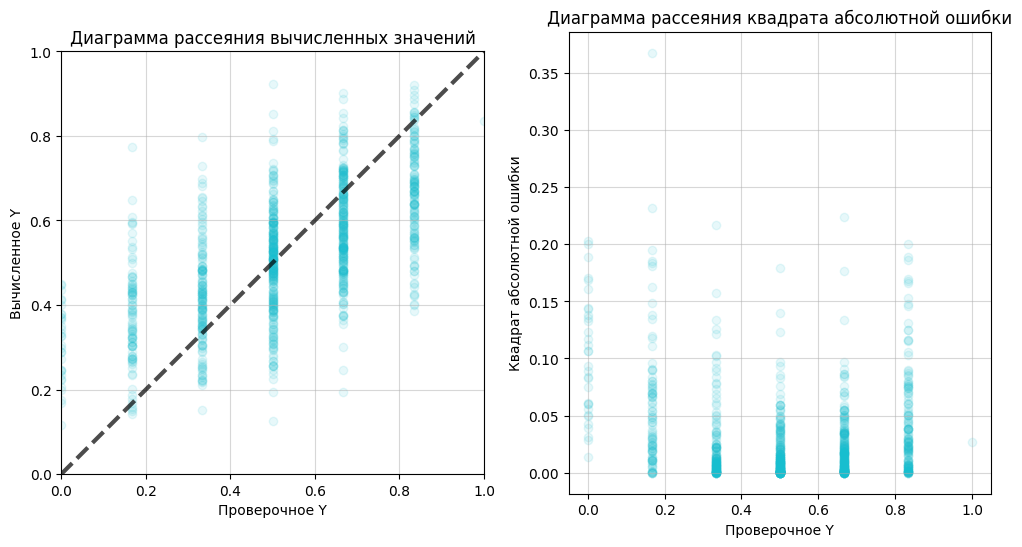

In [98]:
yNorm_pred = model.predict(
    xNorm_test[features_from_lab1]
)  
GET_METRICS_SINGLE(yNorm_test, yNorm_pred) 
PLOT34(yNorm_test, yNorm_pred)

In [99]:
printModelWeights(model)

####################################################################################################
#### Имя слоя:dense_10;  Тип слоя: <class 'keras.src.layers.core.dense.Dense'> ##########
Вид ф-ии активации слоя: linear
Кол-во ВХодов  слоя: 6
Кол-во ВЫХодов слоя: 1
Кол-во нейронов слоя:    1

Весовые коэфф. weight_i_j=
[[-0.41453534]
 [ 0.2186807 ]
 [ 0.04910067]
 [ 0.1635085 ]
 [ 0.05648076]
 [ 0.05796937]]

Весовые коэфф. bias_i_j=
[0.4826858]




# Нейронная сеть m4. Построение модели со скрытыми слоями от множества "x"  (6_вх -> 64 -> 64 -> 64 -> 64 ->1_вых)

In [100]:
totalHistoryLossTrain = []
totalHistoryLossTest = []


model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(6,)))

model.add(tf.keras.layers.Dense(units=64, activation=None))
model.add(tf.keras.layers.Activation(activation=tf.keras.activations.relu))

model.add(tf.keras.layers.Dense(units=64, activation=None))
model.add(tf.keras.layers.Activation(activation=tf.keras.activations.relu))

model.add(tf.keras.layers.Dense(units=64, activation=None))
model.add(tf.keras.layers.Activation(activation=tf.keras.activations.relu))

model.add(tf.keras.layers.Dense(units=64, activation=None))
model.add(tf.keras.layers.Activation(activation=tf.keras.activations.relu))

model.add(tf.keras.layers.Dense(units=1, activation=None))

fLoss = tf.keras.losses.MeanSquaredError()

fOptimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
fMetricList = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]

model.compile(loss=fLoss, optimizer=fOptimizer, metrics=fMetricList)

print(model.summary())


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,993 (50.75 KB)

 Trainable params: 12,993 (50.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [101]:
epochForTrain = 40

history = model.fit(
    xNorm_train[features_from_lab1],
    yNorm_train,
    validation_data=(xNorm_test[features_from_lab1], yNorm_test),
    epochs=epochForTrain,
    verbose=1,
)

totalHistoryLossTrain.extend(history.history["loss"])
if "val_loss" in history.history.keys():
    totalHistoryLossTest.extend(history.history["val_loss"])

Epoch 1/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0614 - mean_absolute_error: 0.1875 - mean_squared_error: 0.0609 - val_loss: 0.0359 - val_mean_absolute_error: 0.1563 - val_mean_squared_error: 0.0357
Epoch 2/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0306 - mean_absolute_error: 0.1409 - mean_squared_error: 0.0309 - val_loss: 0.0295 - val_mean_absolute_error: 0.1359 - val_mean_squared_error: 0.0292
Epoch 3/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0304 - mean_absolute_error: 0.1394 - mean_squared_error: 0.0301 - val_loss: 0.0314 - val_mean_absolute_error: 0.1396 - val_mean_squared_error: 0.0313
Epoch 4/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0298 - mean_absolute_error: 0.1376 - mean_squared_error: 0.0297 - val_loss: 0.0298 - val_mean_absolute_error: 0.1353 - val_mean_squared_error: 0.0294
Epoch 5/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0303 - mean_absolute_error: 0.1407 - mean_squared_error: 0.0306 - val_loss: 0.0321 - val_mean_absol

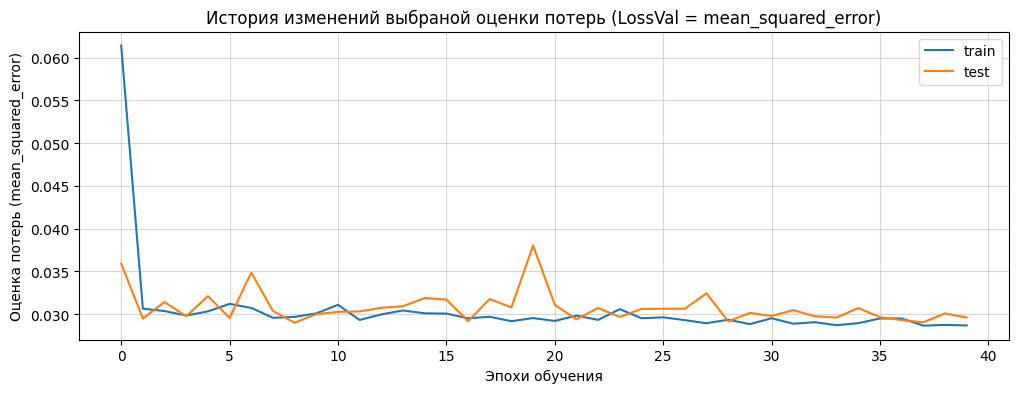

In [102]:
plt.figure(figsize=(12, 4))
plt.plot(totalHistoryLossTrain, label="train", color="#1f77b4")
plt.plot(totalHistoryLossTest, label="test", color="#ff7f0e")
plt.title("История изменений выбраной оценки потерь (LossVal = mean_squared_error)")
plt.ylabel("Оценка потерь (mean_squared_error)")
plt.xlabel("Эпохи обучения")
plt.legend()
plt.grid(True, alpha=0.5)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE :     0.137 (средняя абсолютная ошибка)
MSE :  0.029596 (среднеквадратичная ошибка)
RMSE:  0.172034 (кв. корень из среднеквадратичной ошибки)
R2  :     0.400 (коэфф. детерминации)


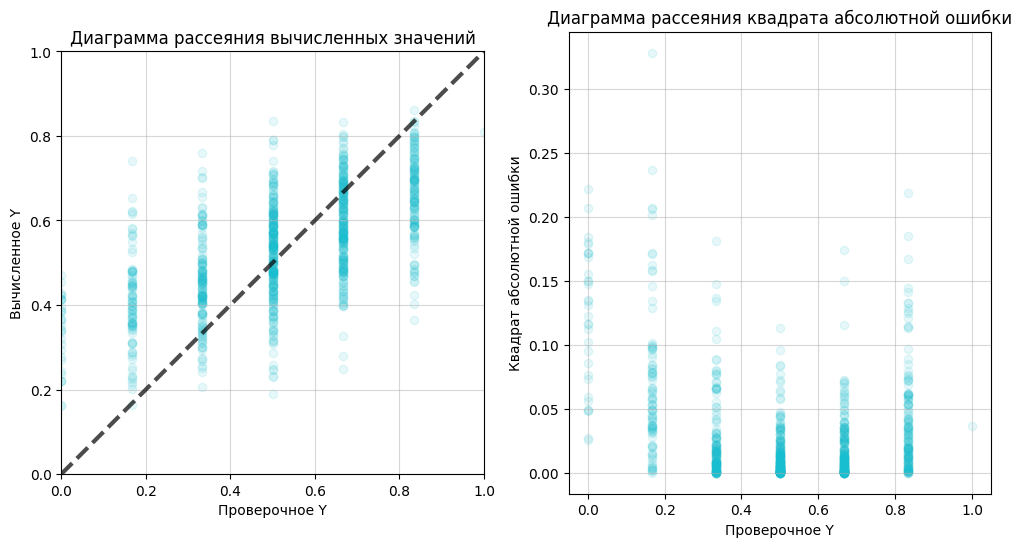

In [103]:
yNorm_pred = model.predict(xNorm_test[features_from_lab1])

GET_METRICS_SINGLE(yNorm_test, yNorm_pred)
PLOT34(yNorm_test, yNorm_pred)

In [104]:
import json

model_info = {
    "model_type": "Нейронная сеть на 6 параметрах",
    "needs_scaling": True,
    "features": features_from_lab1,
    "target": target,
    "R2": 0.400,
    "RMSE": 0.172034,
    "coefs": "",
    "x_scaler": "scalerX_NN_6.pkl",
    "y_scaler": "scalerY_NN.pkl"
}

json.dump(model_info, open("NN_6.json", "w"), indent=4)

In [105]:
model.save('NN_6.keras')

# Нейронная сеть m5. Построение модели без скрытых слоев от множества "x"  (17_вх->1_вых)

In [58]:
totalHistoryLossTrain = []
totalHistoryLossTest = []


model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(17,)))

model.add(tf.keras.layers.Dense(units=1, activation=None))

fLoss = tf.keras.losses.MeanSquaredError()

fOptimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
fMetricList = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]

model.compile(loss=fLoss, optimizer=fOptimizer, metrics=fMetricList)

print(model.summary())


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 1)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18 (72.00 B)

 Trainable params: 18 (72.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [59]:
epochForTrain = 40

history = model.fit(
    xNorm_train,
    yNorm_train,
    validation_data=(xNorm_test, yNorm_test),
    epochs=epochForTrain,
    verbose=1,
)

totalHistoryLossTrain.extend(history.history["loss"])
if "val_loss" in history.history.keys():
    totalHistoryLossTest.extend(history.history["val_loss"])

Epoch 1/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1383 - mean_absolute_error: 0.2947 - mean_squared_error: 0.1373 - val_loss: 0.0598 - val_mean_absolute_error: 0.1962 - val_mean_squared_error: 0.0583
Epoch 2/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0512 - mean_absolute_error: 0.1831 - mean_squared_error: 0.0513 - val_loss: 0.0411 - val_mean_absolute_error: 0.1609 - val_mean_squared_error: 0.0399
Epoch 3/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0371 - mean_absolute_error: 0.1548 - mean_squared_error: 0.0369 - val_loss: 0.0342 - val_mean_absolute_error: 0.1478 - val_mean_squared_error: 0.0334
Epoch 4/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0319 - mean_absolute_error: 0.1437 - mean_squared_error: 0.0319 - val_loss: 0.0310 - val_mean_absolute_error: 0.1390 - val_mean_squared_error: 0.0303
Epoch 5/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0302 - mean_absolute_error: 0.1397 - mean_squared_error: 0.0302 - val_loss: 0.0303 - val_mean_absol

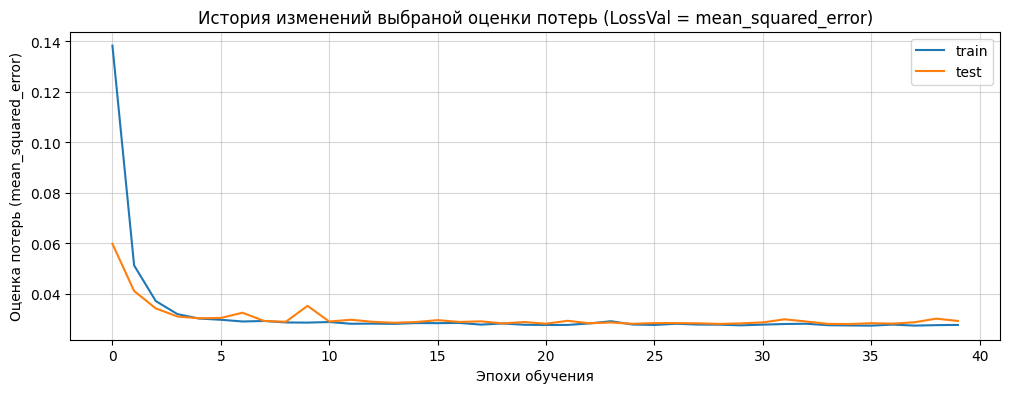

In [60]:
plt.figure(figsize=(12, 4))
plt.plot(totalHistoryLossTrain, label="train", color="#1f77b4")
plt.plot(totalHistoryLossTest, label="test", color="#ff7f0e")
plt.title("История изменений выбраной оценки потерь (LossVal = mean_squared_error)")
plt.ylabel("Оценка потерь (mean_squared_error)")
plt.xlabel("Эпохи обучения")
plt.legend()
plt.grid(True, alpha=0.5)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE :     0.137 (средняя абсолютная ошибка)
MSE :  0.029235 (среднеквадратичная ошибка)
RMSE:  0.170983 (кв. корень из среднеквадратичной ошибки)
R2  :     0.408 (коэфф. детерминации)


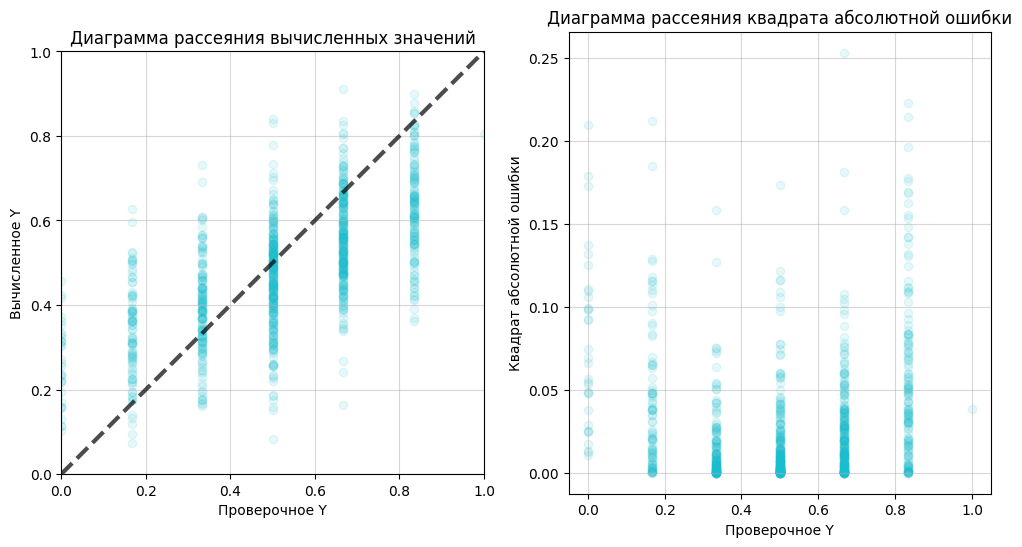

In [61]:
yNorm_pred = model.predict(
    xNorm_test
) 
GET_METRICS_SINGLE(yNorm_test, yNorm_pred)  
PLOT34(yNorm_test, yNorm_pred)

# Нейронная сеть m6. Построение модели со скрытыми слоями от множества "x"  (17_вх-> 256 -> 256 -> 64 ->1_вых)

In [74]:
totalHistoryLossTrain = []
totalHistoryLossTest = []


model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(17,)))

model.add(tf.keras.layers.Dense(units=256, activation=tf.keras.activations.relu))

model.add(tf.keras.layers.Dense(units=256, activation=tf.keras.activations.relu))

model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))

model.add(tf.keras.layers.Dense(units=1, activation=None))

fLoss = tf.keras.losses.MeanSquaredError()

fOptimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
fMetricList = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]

model.compile(loss=fLoss, optimizer=fOptimizer, metrics=fMetricList)

print(model.summary())


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 256)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,913 (339.50 KB)

 Trainable params: 86,913 (339.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [75]:
epochForTrain = 50

history = model.fit(
    xNorm_train,
    yNorm_train,
    validation_data=(xNorm_test, yNorm_test),
    epochs=epochForTrain,
    verbose=1,
)

totalHistoryLossTrain.extend(history.history["loss"])
if "val_loss" in history.history.keys():
    totalHistoryLossTest.extend(history.history["val_loss"])

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0852 - mean_absolute_error: 0.1994 - mean_squared_error: 0.0844 - val_loss: 0.0344 - val_mean_absolute_error: 0.1451 - val_mean_squared_error: 0.0335
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0312 - mean_absolute_error: 0.1425 - mean_squared_error: 0.0314 - val_loss: 0.0286 - val_mean_absolute_error: 0.1341 - val_mean_squared_error: 0.0282
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0306 - mean_absolute_error: 0.1409 - mean_squared_error: 0.0308 - val_loss: 0.0396 - val_mean_absolute_error: 0.1656 - val_mean_squared_error: 0.0398
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0297 - mean_absolute_error: 0.1389 - mean_squared_error: 0.0298 - val_loss: 0.0281 - val_mean_absolute_error: 0.1322 - val_mean_squared_error: 0.0277
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0280 - mean_absolute_error: 0.1341 - mean_squared_error: 0.0279 - val_loss: 0.0320 - val_mean_ab

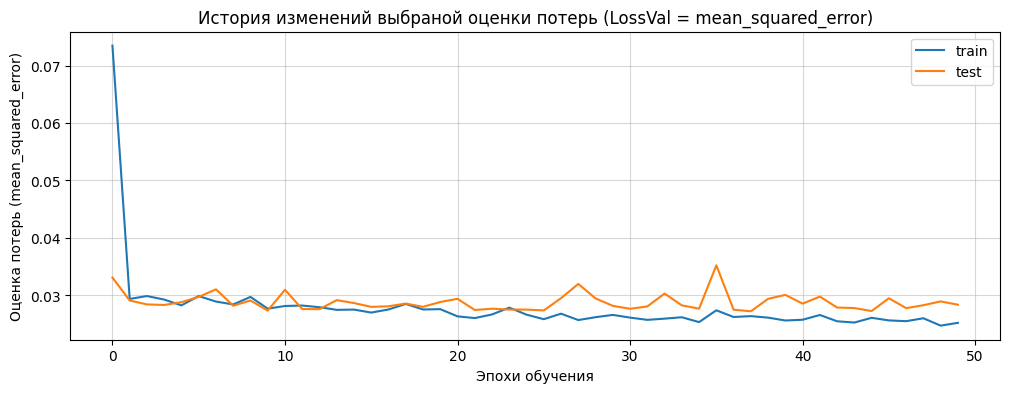

In [64]:
plt.figure(figsize=(12, 4))
plt.plot(totalHistoryLossTrain, label="train", color="#1f77b4")
plt.plot(totalHistoryLossTest, label="test", color="#ff7f0e")
plt.title("История изменений выбраной оценки потерь (LossVal = mean_squared_error)")
plt.ylabel("Оценка потерь (mean_squared_error)")
plt.xlabel("Эпохи обучения")
plt.legend()
plt.grid(True, alpha=0.5)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MAE :     0.133 (средняя абсолютная ошибка)
MSE :  0.027698 (среднеквадратичная ошибка)
RMSE:  0.166426 (кв. корень из среднеквадратичной ошибки)
R2  :     0.439 (коэфф. детерминации)


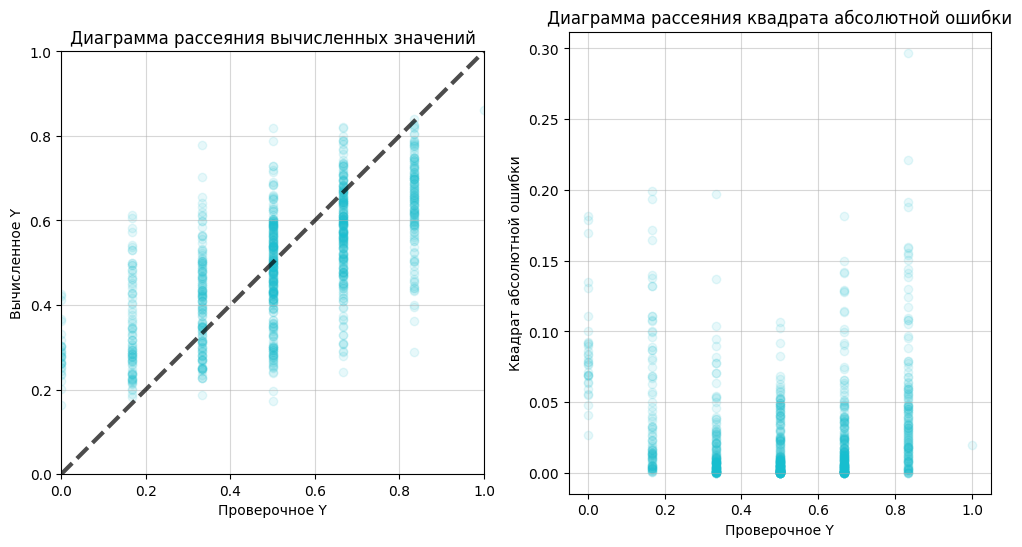

In [76]:
yNorm_pred = model.predict(xNorm_test)

GET_METRICS_SINGLE(yNorm_test, yNorm_pred)
PLOT34(yNorm_test, yNorm_pred)

In [ ]:
model.save('NN_17.keras')

In [ ]:
model.save('NN_17.keras')

import json

model_info = {
    "model_type": "Нейронная сеть на 17 параметрах",
    "needs_scaling": True,
    "features": features,
    "target": target,
    "R2": 0.439,
    "RMSE": 0.166426,
    "coefs": "NN_17.keras"
}

json.dump(model_info, open("NN_17.json", "w"), indent=4)

# Нейронная сеть m7. Построение модели со скрытыми слоями от множества "x"  (17_вх-> 256 -> 256 -> 256 ->7_вых)

In [66]:
yNorm_train.nunique()

LeagueIndex    7
dtype: int64

In [67]:
from sklearn.preprocessing import LabelEncoder

encode = LabelEncoder()
yNorm_train_encoded = encode.fit_transform(yNorm_train.values.ravel())
yNorm_test_encoded = encode.transform(yNorm_test.values.ravel())

In [68]:
totalHistoryLossTrain = []
totalHistoryLossTest = []


model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(17,)))

model.add(tf.keras.layers.Dense(units=256, activation=None))
model.add(tf.keras.layers.Activation(activation=tf.keras.activations.relu))

model.add(tf.keras.layers.Dense(units=256, activation=None))
model.add(tf.keras.layers.Activation(activation=tf.keras.activations.relu))

model.add(tf.keras.layers.Dense(units=256, activation=None))
model.add(tf.keras.layers.Activation(activation=tf.keras.activations.relu))

model.add(tf.keras.layers.Dense(units=7, activation=None))

fLoss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

fOptimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
fMetricList = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]

model.compile(loss=fLoss, optimizer=fOptimizer, metrics=["accuracy"])

print(model.summary())


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,991 (539.03 KB)

 Trainable params: 137,991 (539.03 KB)

 Non-trainable params: 0 (0.00 B)

None


In [69]:
epochForTrain = 30

history = model.fit(
    xNorm_train,
    yNorm_train_encoded,
    validation_data=(xNorm_test, yNorm_test_encoded),
    epochs=epochForTrain,
    verbose=1,
)

totalHistoryLossTrain.extend(history.history["loss"])
if "val_loss" in history.history.keys():
    totalHistoryLossTest.extend(history.history["val_loss"])

Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3002 - loss: 1.5543 - val_accuracy: 0.3733 - val_loss: 1.3964
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3778 - loss: 1.4265 - val_accuracy: 0.3548 - val_loss: 1.4252
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3679 - loss: 1.4074 - val_accuracy: 0.3859 - val_loss: 1.3837
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3709 - loss: 1.4022 - val_accuracy: 0.3779 - val_loss: 1.3605
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3798 - loss: 1.4021 - val_accuracy: 0.3756 - val_loss: 1.3677
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3812 - loss: 1.3805 - val_accuracy: 0.3848 - val_loss: 1.4073
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3758 - loss: 1.3961 - val_accuracy: 0.3664 - val_loss: 1.3964
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3906 - loss: 1.3884 - val_accuracy: 0.3802 - val_loss

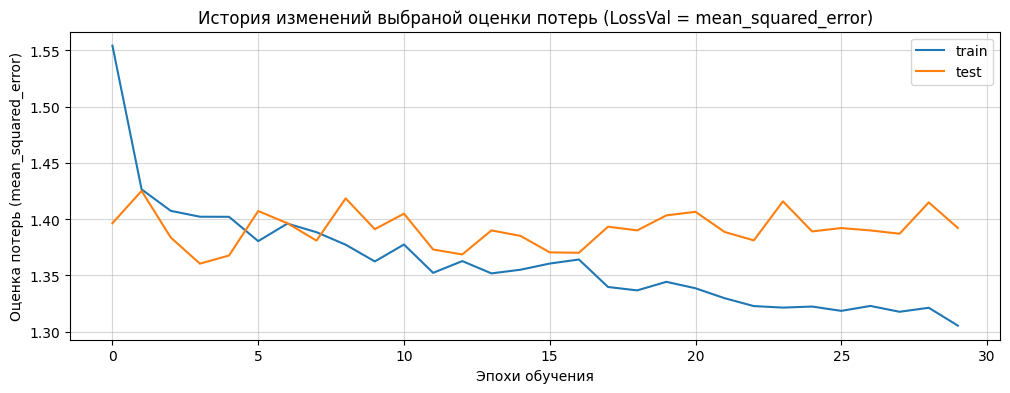

In [70]:
plt.figure(figsize=(12, 4))
plt.plot(totalHistoryLossTrain, label="train", color="#1f77b4")
plt.plot(totalHistoryLossTest, label="test", color="#ff7f0e")
plt.title("История изменений выбраной оценки потерь (LossVal = mean_squared_error)")
plt.ylabel("Оценка потерь (mean_squared_error)")
plt.xlabel("Эпохи обучения")
plt.legend()
plt.grid(True, alpha=0.5)

In [71]:
yNorm_pred = model.predict(xNorm_test)

y_test = scalerNormY.inverse_transform(yNorm_test)

from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(y_test.ravel().astype("int"), (yNorm_pred.argmax(axis=1) + 1))
rep = classification_report(y_test.ravel().astype("int"), (yNorm_pred.argmax(axis=1) + 1))

print(f"Accuracy: {acc:.4f}")
print("\nClassification report:\n", rep)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.3779

Classification report:
               precision    recall  f1-score   support

           1       0.20      0.22      0.21        32
           2       0.27      0.05      0.08        86
           3       0.30      0.42      0.35       138
           4       0.39      0.50      0.44       248
           5       0.42      0.25      0.32       226
           6       0.45      0.57      0.50       138

    accuracy                           0.38       868
   macro avg       0.34      0.33      0.32       868
weighted avg       0.37      0.38      0.36       868



# Сравнение полученных моделей

Приведите все численные оценки всех моделей для более удобного сравнения.

Пример в текстовом виде:

      M1.
        Структура: '___'.
        Признаки: '___'.
        ЭпохОбучения: '___'.
        MAE : ___ (средняя абсолютная ошибка)
        RMSE: ___ (кв. корень из среднеквадратичной ошибки)
        R2  : ___ (коэфф. детерминации)

      M2 ...

Пример в табличном виде:

In [72]:
df_model_results = pd.DataFrame(
    [
        {
            "Признаки": "APM, NumberOfPACs",
            "Структура": "2вх->1вых",
            "ЭпохОбучения": 20,
            "R2": 0.344,
            "RMSE": 0.180,
        },
        {
            "Признаки": "APM, NumberOfPACs",
            "Структура": "2вх-> 20 -> 20 -> 20 ->1вых",
            "ЭпохОбучения": 40,
            "R2": 0.366,
            "RMSE": 0.177,
        },
        {
            "Признаки": "6 признаков из ЛР1",
            "Структура": "6вх -> 1вых",
            "ЭпохОбучения": 40,
            "R2": 0.389,
            "RMSE": 0.174,
        },
        {
            "Признаки": "6 признаков из ЛР1",
            "Структура": "6вх-> 64 -> 64 -> 64 -> 64 ->1вых",
            "ЭпохОбучения": 50,
            "R2": 0.387,
            "RMSE": 0.174,
        },
                {
            "Признаки": "17 признаков (все)",
            "Структура": "17вх->1вых",
            "ЭпохОбучения": 30,
            "R2": 0.428,
            "RMSE": 0.168,
        },
        {
            "Признаки": "17 признаков (все)",
            "Структура": "17вх-> 256 -> 256 -> 64 ->1вых",
            "ЭпохОбучения": 30,
            "R2": 0.397,
            "RMSE": 0.172,
        },
    ]
)
df_model_results

,Признаки,Структура,ЭпохОбучения,R2,RMSE
0,"APM, NumberOfPACs",2вх->1вых,20,0.344,0.180
1,"APM, NumberOfPACs",2вх-> 20 -> 20 -> 20 ->1вых,40,0.366,0.177
2,6 признаков из ЛР1,6вх -> 1вых,40,0.389,0.174
3,6 признаков из ЛР1,6вх-> 64 -> 64 -> 64 -> 64 ->1вых,50,0.387,0.174
4,17 признаков (все),17вх->1вых,30,0.428,0.168
5,17 признаков (все),17вх-> 256 -> 256 -> 64 ->1вых,30,0.397,0.172


# Итоговые, сводные результаты и выводы.

Оцените в минутах время затраченное на выполнение основных этапов текущей работы, согласно методологии CRISP, затем заполните эту информацию в следующей ячейке для получения диаграммы.

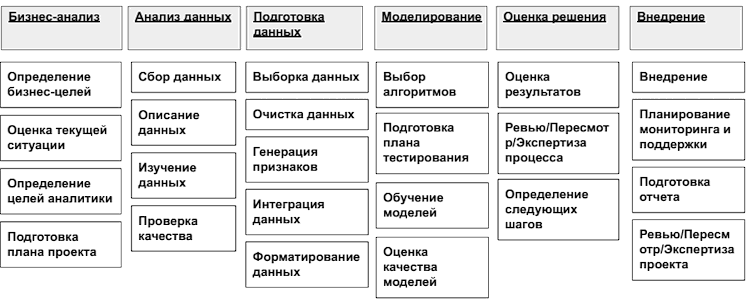

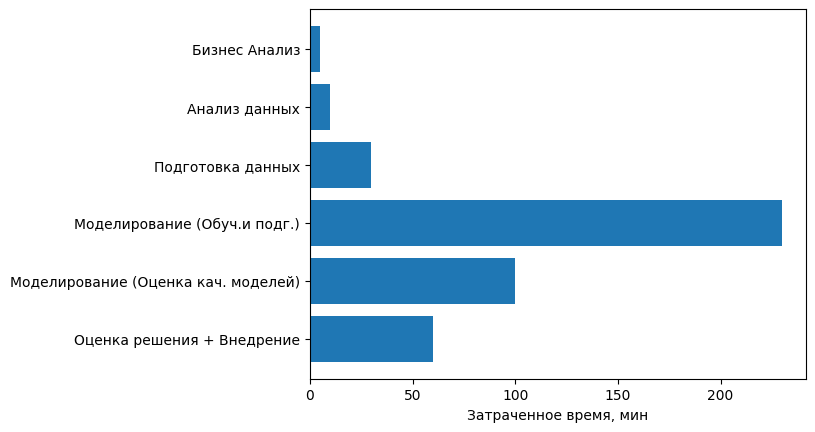

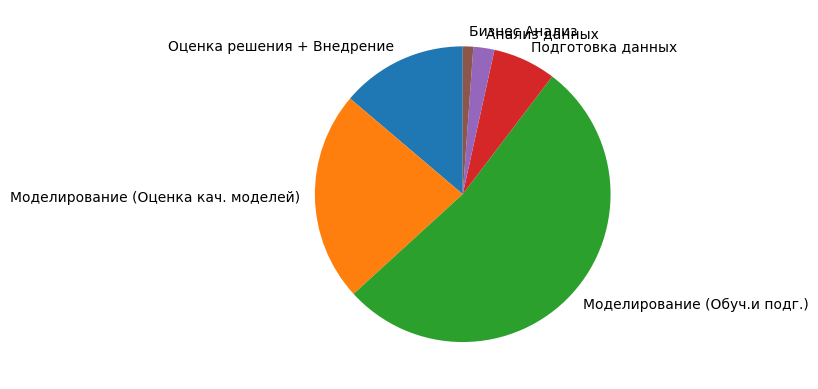

In [73]:
# Создадим датафрейм для хранения значений
dfSpendTimeLab3 = pd.DataFrame.from_dict(
{
  "1": {"step": "Бизнес Анализ",                       "duration, min" :  5  },
  "2": {"step": "Анализ данных",                       "duration, min" :  10  },
  "3": {"step": "Подготовка данных",                   "duration, min" :  30  },
  "4": {"step": "Моделирование (Обуч.и подг.)",        "duration, min" :  230  },
  "5": {"step": "Моделирование (Оценка кач. моделей)", "duration, min" :  100  },
  "6": {"step": "Оценка решения + Внедрение",          "duration, min" :  60  },
}
, orient="index"
).sort_index(ascending=False)

# Построить столбчатую диаграмму
fig = plt.figure()
plt.barh(y = dfSpendTimeLab3["step"], width= dfSpendTimeLab3["duration, min"], )
plt.xlabel("Затраченное время, мин")

# Построить круговую диаграмму
fig = plt.figure()
plt.pie(x= dfSpendTimeLab3["duration, min"], labels=dfSpendTimeLab3["step"],  startangle = 90 )

plt.show()

# Выводы по работе

- Как в целом влияет структура модели (кол-во слоев и количество нейронов на каждом слое):
  - на итоговую точность модели?
  - на время необходимое для получение приемлемых результатов?
- Оцените эффективность применения нейронных сетей на вашем наборе данных
- Сравните точность моделей m3 и m4 и сделайте предположения о причинах совпадения/различия точности

- Увеличение слоев и нейронов замедляет скорость обучения и по-разному влияет на точность модели. Так, добавление слоев и нейронов для 1-ого набора признаков позволило увеличить метрику R2 на 0.22, но для двух других наборов добавление слоев и нейронов не принесло прироста.
- Применение нейронных сетей на данном наборе даннных является не самым эффективным решением, поскольку метрики почти не отличаются или получаются хуже, чем у линейной регрессии.
- Для моделей 3 и 4 (Аналогично и для 5 и 6) точность с добавлением слоев и нейронов падает (R2 упало с 0.389 до 0.387 для m3,m4 и с 0.428 до 0.397 для m5, m6). Связано это с тем, что данный набор признаков не позволяет получить лучшее приближение данных.